In [59]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import itertools


def plot(image):
    plt.figure()
    plt.imshow(image.reshape((32, 32)) if image.shape[0] != 32 else image, cmap="gray")
    plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation="none", cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # return fig


# Get data

In [60]:
import keras.datasets.cifar10 as cifar10

(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

ytrain = ytrain.squeeze()
ytest = ytest.squeeze()

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


# Randomize train data and sort test data

In [61]:
idx = rnd.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx]
ytrain = ytrain[idx]

idx = np.argsort(ytest)
Xtest = Xtest[idx]
ytest = ytest[idx]


# Convert images to grayscale

In [62]:
from skimage import color

XtrainG = np.zeros((Xtrain.shape[0], 32, 32))
for i in range(Xtrain.shape[0]):
    XtrainG[i] = color.rgb2gray(Xtrain[i])

XtestG = np.zeros((Xtest.shape[0], 32, 32))
for i in range(Xtest.shape[0]):
    XtestG[i] = color.rgb2gray(Xtest[i])


# Convert images to vectors

In [63]:
XtrainG = XtrainG.reshape((XtrainG.shape[0], XtrainG.shape[1] ** 2)) * 1.0
XtestG = XtestG.reshape((XtestG.shape[0], XtestG.shape[1] ** 2)) * 1.0

print(XtrainG.shape, ytrain.shape)
print(XtestG.shape, ytest.shape)


(50000, 1024) (50000,)
(10000, 1024) (10000,)


# Normalization

In [64]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(XtrainG)
XtrainGS = ss.transform(XtrainG)
XtestGS = ss.transform(XtestG)


# Binarize for ship (index 8)

In [65]:
ytrainB = (ytrain == 8) * 1
ytestB = (ytest == 8) * 1


# Train and test model

In [66]:
from sklearn.linear_model import SGDClassifier  # Try differents

X1 = XtrainG
y1 = ytrain
X2 = XtestG
y2 = ytest

sgd = SGDClassifier().fit(X1, y1)
y2e = sgd.predict(X2)


Number of errors: 8019


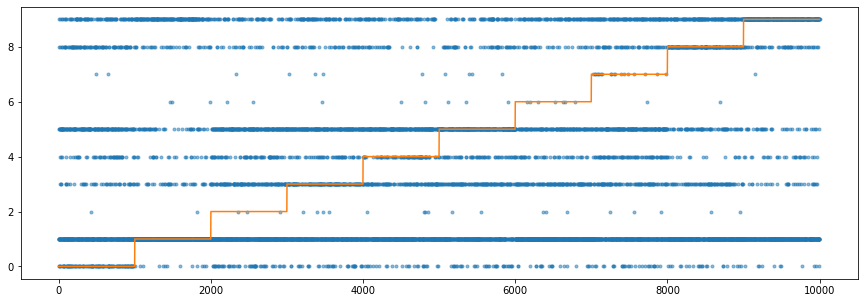

In [67]:
print("Number of errors:", np.sum(y2 != y2e))

plt.figure(figsize=(15, 5))
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)


Confusion matrix, without normalization


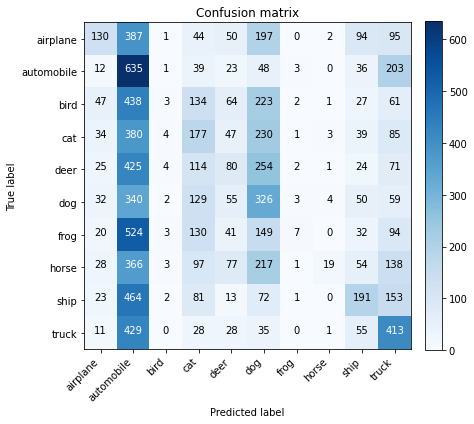

In [71]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y2, y2e)

# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


# Example preview

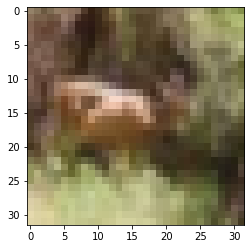

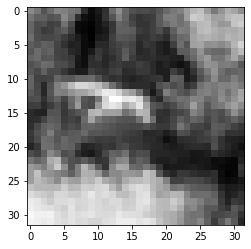

4


In [69]:
plot(Xtrain[0])
plot(XtrainG[0])
print(ytrain[0])
